# Аналитика в авиакомпании

## 1. Получение данных из SQL

**Изучите таблицу flights и подсчитайте количество вылетов (flight_id) из каждого аэропорта вылета (departure_airport). Назовите переменную cnt_flights и выведите её вместе со столбцом departure_airport — сначала departure_airport, потом cnt_flights. Результат отсортируйте в порядке убывания количества вылетов:**
SELECT
departure_airport,
 COUNT(flight_id) AS cnt_flights 
FROM flights 
GROUP BY departure_airport
ORDER BY
cnt_flights DESC

Найдите количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года. Назовите получившийся столбец flights_amount и выведите его, также выведите столбец model.

SELECT
aircrafts.model AS model,
COUNT(flights.flight_id) AS flights_amount
FROM 
aircrafts INNER JOIN flights ON aircrafts.aircraft_code = flights.aircraft_code
WHERE 
CAST(flights.departure_time AS date) BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY model

**Посчитайте количество рейсов по всем моделям самолётов Boeing, Airbus и другим ('other') в сентябре. Типы моделей поместите в столбец type_aircraft, а количество рейсов — во flights_amount.**

SELECT
COUNT(flights.flight_id) AS flights_amount,
CASE WHEN model LIKE 'Airbus%' THEN 'Airbus'
    WHEN model LIKE 'Boeing%' THEN 'Boeing'
    ELSE 'other'
    END AS type_aircraft


FROM aircrafts INNER JOIN flights ON aircrafts.aircraft_code = flights.aircraft_code
WHERE EXTRACT (month from CAST(flights.departure_time AS date)) = '09'
GROUP BY type_aircraft

**Посчитайте среднее количество прибывающих рейсов в день для каждого города за август 2018 года. Назовите получившееся поле average_flights, вместе с ним выведите столбец city**

SELECT CITY,AVG(counter) FROM (
    SELECT airports.CITY, COUNT(*) AS counter
    FROM flights
    JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE EXTRACT(month FROM CAST(flights.ARRIVAL_TIME AS date)) ='08'
    GROUP BY airports.CITY, EXTRACT(DAY FROM CAST(flights.ARRIVAL_TIME AS date))
) AS C
GROUP BY CITY

**Установите фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. Выведите название фестиваля festival_name и номер недели festival_week**

SELECT
    festival_name,
    EXTRACT('week' from CAST(festival_date AS date)) festival_week
FROM
    festivals
WHERE 
     CAST(festival_date AS date) BETWEEN '2018-07-23' AND '2018-09-30'
     AND festival_city = 'Москва'


**Для каждой недели с 23 июля по 30 сентября 2018 года посчитайте количество билетов, купленных на рейсы в Москву (номер недели week_number и количество билетов ticket_amount). Получите таблицу, в которой будет номер недели; информация о количестве купленных за неделю билетов; номер недели ещё раз, если в эту неделю проходил фестиваль, и nan, если не проходил; а также название фестиваля festival_name.**

SELECT
    SUBQ1.week_number,
    SUBQ1.ticket_amount,
    SUBQ2.festival_week AS festival_week,
    SUBQ2.festival_name AS festival_name
FROM
(
    (SELECT
        EXTRACT('week' from CAST(flights.arrival_time AS date)) AS  week_number,
        COUNT(ticket_flights.ticket_no) AS ticket_amount
    FROM flights 
        INNER JOIN airports ON airports.airport_code  = flights.arrival_airport 
        INNER JOIN ticket_flights ON ticket_flights.flight_id = flights.flight_id
    WHERE airports.city = 'Москва'
        AND CAST(flights.arrival_time AS date) BETWEEN '2018-07-23' AND '2018-09-30'
    GROUP BY week_number
    ) AS SUBQ1
LEFT JOIN 
    (SELECT
        festival_name,
        EXTRACT('week' from CAST(festival_date AS date)) festival_week
    FROM festivals
    WHERE 
         CAST(festival_date AS date) BETWEEN '2018-07-23' AND '2018-09-30'
         AND festival_city = 'Москва') as SUBQ2
    ON SUBQ1.week_number =SUBQ2.festival_week
)

## 2. Аналитика средствами Python

Есть файлы, в которых содержатся результаты запросов из предыдущих заданий.

1. 
- модели самолета
- количество рейсов для каждой модели самолетов model в сентябре 2018 года

2. 
- городах
- среднем количестве рейсов, прибывающих в город city за день в августе 2018 года


## 2.1. Изучить данные, проверить типы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
df_list = ['query_1','query_3']
df_dict = {}
for name in df_list:
    try:
        df_dict[name] = pd.read_csv(f'datasets/{name}.csv')  # Локальный путь
    except:
        df_dict[name] = pd.read_csv(f'/datasets/{name}.csv')  # Серверный путь
    print(name)
    df_dict[name].info()
    display(df_dict[name].head())
    print()

query_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300



query_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


### Вывод

В полученных таблицах типы данных соответствуют данным 

## 2.2. Выбрать топ-10 городов по количеству рейсов

In [3]:
top_city = df_dict['query_3'].sort_values(by = 'average_flights', ascending = False).head(10)
top_city

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


### Вывод

В основном распределение по кол-ву рейсов понятен- города миллионники. Непонятно как в топ попали Брянск и Ульяновск, вероятно в данные города чаще летает малая авиация, но данных не достаточно для полного анализа предположения.

## 2.3. Построить графики

 ### Модели самолетов и количество рейсов  

Text(0.5, 1.0, 'Кол-во рейсов по моделям самолетов')

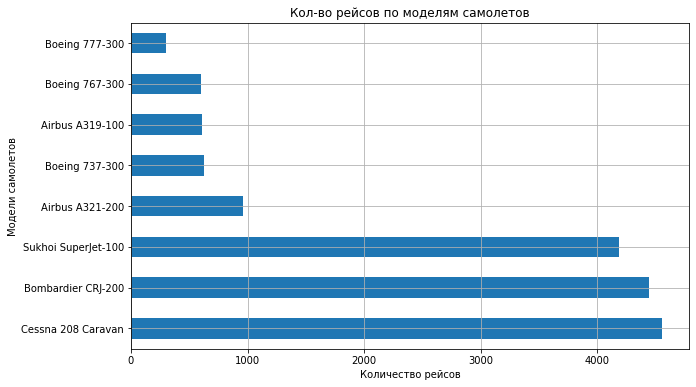

In [4]:
df_dict['query_1'].sort_values(by = 'flights_amount', ascending = False).plot(
    kind ='barh',grid=True, x="model", y="flights_amount",figsize=(10,6), legend=False)
plt.ylabel("Модели самолетов")
plt.xlabel("Количество рейсов")
plt.title("Кол-во рейсов по моделям самолетов")

- [картинка](img/img1.jpg)

#### Вывод

Сравнение вместительности самолетов:
- Cessna 208 Caravan - 9 (до 13) пассажиров + 1 пилот
- Bombardier CRJ-200-  50 пассажиров
- Sukhoi SuperJet-100 - 95 пассажиров
- Airbus A321-200 - 185 пассажиров
- Boeing 737-300 - 129 (до 149) пассажиров
- Airbus A319-100 - 124 (до 156) пассажиров
- Boeing 767-300 - 336 пассажиров
- Boeing 777-300 -  550 пассажиров

Приведенными выше данными о вместительности самолетов объясняется кол-во вылетов у топ-3 моделей по кол-ву вылетов. Airbus A321-200 идет следующим вероятно из-за большого парка данных моделей у лидирующих авиакомпаний (для обоснования теории не достаточно данных).  

### Города и количество рейсов

Text(0.5, 1.0, 'Кол-во рейсов по городам')

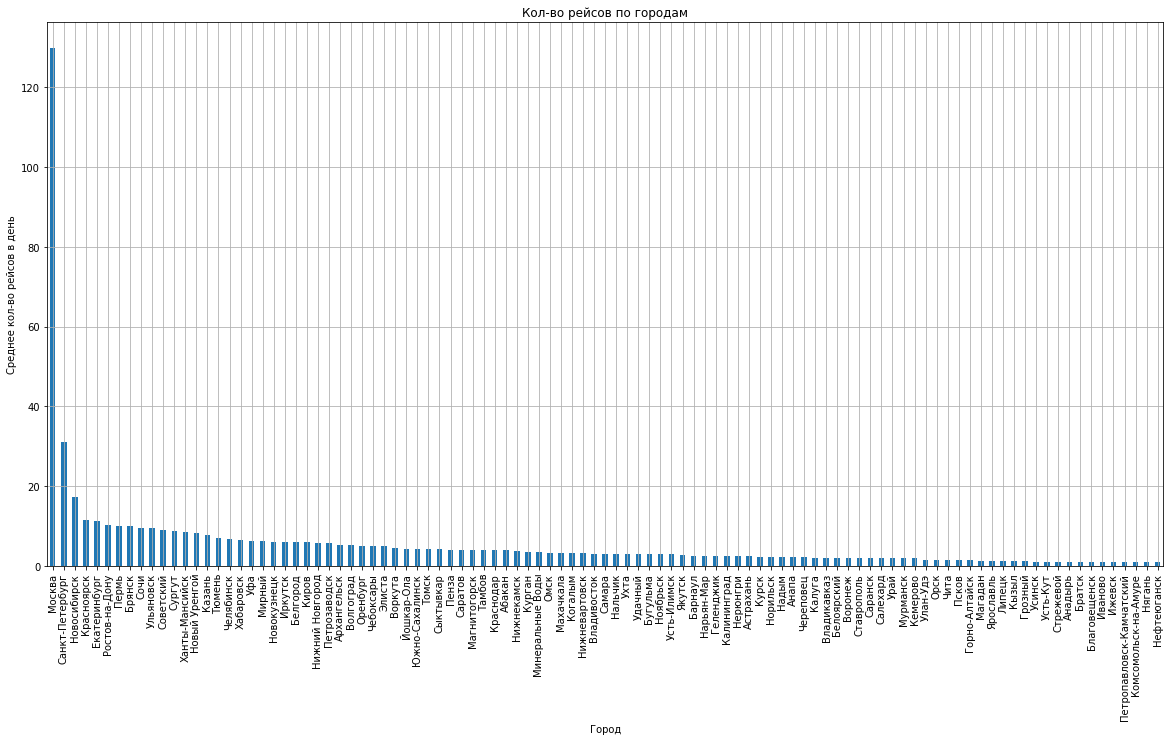

In [5]:
df_dict['query_3'].sort_values(by = 'average_flights', ascending = False).plot(
    kind ='bar',grid=True, x="city", y="average_flights",figsize=(20,10), legend=False)
plt.ylabel("Среднее кол-во рейсов в день")
plt.xlabel("Город")
plt.title("Кол-во рейсов по городам")

- [картинка](img/img2.jpg)

Text(0.5, 1.0, 'Кол-во рейсов по городам без топ-10')

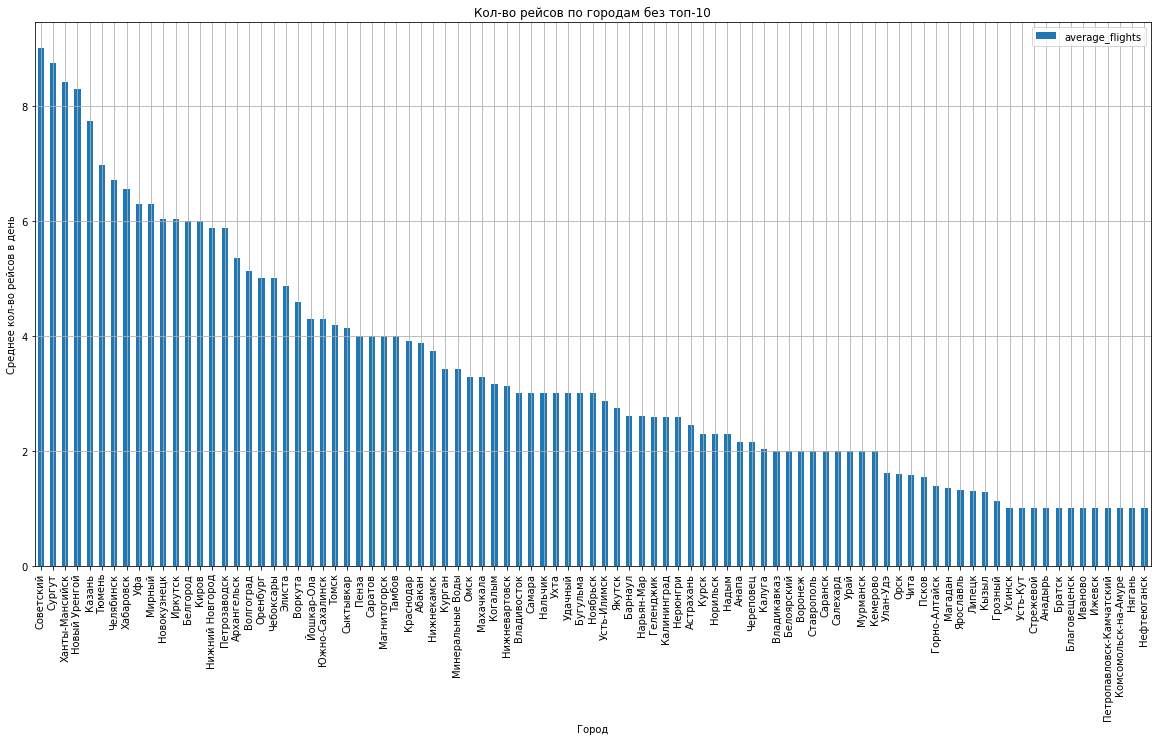

In [6]:
df_dict['query_3'].sort_values(by = 'average_flights',
                  ascending = False).tail(91).plot(kind ='bar',grid=True, x="city", y="average_flights",figsize=(20,10))
plt.ylabel("Среднее кол-во рейсов в день")
plt.xlabel("Город")
plt.title("Кол-во рейсов по городам без топ-10")      

- [картинка](img/img3.jpg)

### Топ-10 городов и количество рейсов

Text(0.5, 1.0, 'Кол-во рейсов по топ-10 городов')

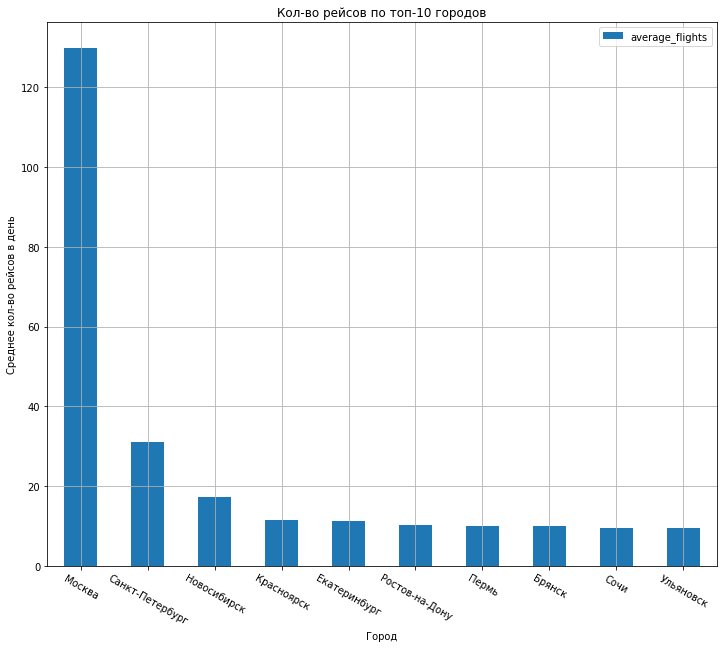

In [7]:
top_city.plot(kind ='bar',grid=True, x="city", rot=-30, y="average_flights",figsize=(12,10))
plt.ylabel("Среднее кол-во рейсов в день")
plt.xlabel("Город")
plt.title("Кол-во рейсов по топ-10 городов")

- [картинка](img/img4.jpg)

Text(0.5, 1.0, 'Кол-во рейсов по городам без МСК и СПБ')

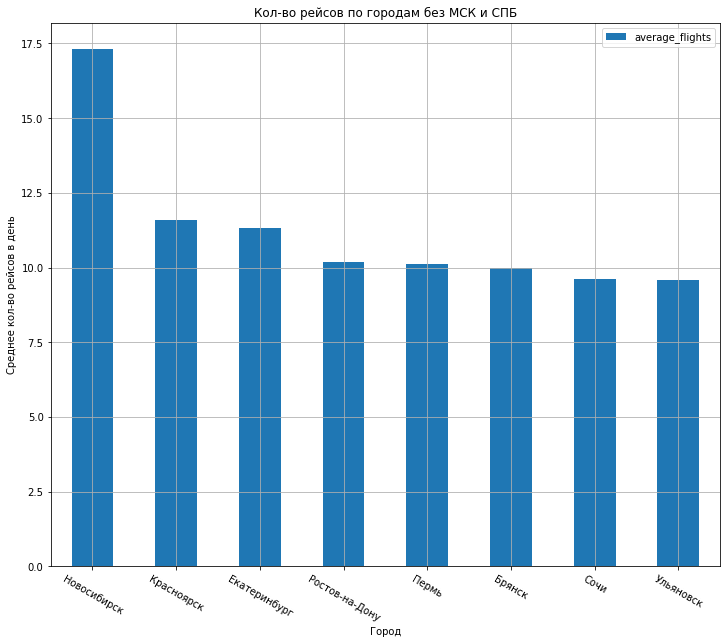

In [8]:
top_city.tail(8).plot(kind ='bar',grid=True, x="city", rot=-30, y="average_flights",figsize=(12,10))
plt.ylabel("Среднее кол-во рейсов в день")
plt.xlabel("Город")
plt.title("Кол-во рейсов по городам без МСК и СПБ")

- [картинка](img/img5.jpg)

#### Вывод

Выдающимися по кол-ву рейсов являются Москва и Санкт-Петербург, где среднее кол-во рейсов 129 и 31 соответственно.
Если рассмотреть детально топ-10 городов, то в них попадают города миллионники. Так же в топ попали Брянск, Сочи и Ульяновск.
Полагаю что такое кол-во рейсов в Брянске обусловлено близостью к Белоруссии и/или использованием по данному направлению малой авиации;
Сочи- курортный город, а рассмотренный период попадает на курортный сезон;
Ульяновск вероятно является региональным транспортным узлом и/или использованием по данному направлению малой авиации.


Остальные города значительно отстают по кол-ву рейсов в день от топ-10 и являются регионнальными транспортыми узлами или отдаленными городами, куда иначе не добраться.

### Общий вывод

**"изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали."**

Большей популярностью авиаперевозок пользуются крупнейшие города РФ, где сосредоточены, как основные транспортные узлы, так и культурная жизнь, отраженная в виде фестивалей в предоставленной выборке.
На 3м шаге был проведен анализ по Москве в "фестивальные недели", но прямой зависимости не выявлено.